In [126]:
import pandas as pd
import os
import re
import datetime
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import pickle
from matplotlib import pyplot as plt
from sklearn import tree
import graphviz
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import plotly.express as px

In [127]:
main1 = pd.read_csv('model/stackoverflow_main.csv')
main2 = pd.read_csv('model/stackoverflow_main_2.csv')
main3 = pd.read_csv('model/stackoverflow_main3.csv')
main4 = pd.read_csv('model/stackoverflow_main4.csv')

In [128]:
data = main1.append(main2)
data = data.append(main3)
data = data.append(main4)

In [129]:
data = data.reset_index()

In [130]:
data = data.sample(frac = 1)

--------------DATA CLEANUP------------------

In [131]:
data = data.drop(columns='Unnamed: 0')

In [132]:
data['id'] = data['id'].apply(lambda x: x[x.find('question-summary-') + 17:]).astype(int)

In [133]:
data['answer']=data['answer'].str.extract(r'(\d)').astype(int)

In [134]:
data['views']=data['views'].str.extract(r'(\d)').astype(int)

In [135]:
data['user_reputation_score']= data.user_reputation_score.replace(',','', regex=True)
data['user_reputation_score']= (data.user_reputation_score.replace(r'[km]+$', '', regex=True).astype(float) * data.user_reputation_score.str.extract(r'[\d\.]+([km]+)', expand=False).fillna(1).replace(['k','m'], [10**3, 10**6]).astype(int))

In [136]:
data['user_badge_number'] = data.user_badge.str.extract(r'(\d)')

In [137]:
data['user_badge_type'] = data.user_badge.str.extract('([a-zA-Z]+)', expand=True)

In [138]:
data['tags_count'] = data.tags.str.split(':').str.len()-1

In [139]:
max_date = pd.to_datetime(data.question_time.max())

In [140]:
def days_in_batch(max_date, questiondate ):

    x = max_date - questiondate
    x = x.days
    if x == 0:
        return 1
    return x

In [141]:
data['question_time'] = pd.to_datetime(data['question_time'])
data['days_in_queue'] = data['question_time'].apply(lambda x: days_in_batch(max_date, x))

In [142]:
data['tags_count'].value_counts()

3    58159
2    51935
4    42211
5    33836
1    24157
Name: tags_count, dtype: int64

In [143]:
stack_features = data[['user_reputation_score', 'votes','answer', 'views', 'accepted_answer', 'user_badge_number','user_badge_type', 'tags_count', 'days_in_queue']]
stack_features

,user_reputation_score,votes,answer,views,accepted_answer,user_badge_number,user_badge_type,tags_count,days_in_queue
187350,311.0,1,1,2,0,1,silver,2,27
108100,54.0,1,1,6,0,2,bronze,3,17
159076,21.0,0,2,3,0,3,bronze,2,24
63209,26.0,0,2,3,0,3,bronze,4,12
107187,161.0,1,2,5,1,1,silver,5,17
...,...,...,...,...,...,...,...,...,...
155582,25700.0,0,1,3,0,5,gold,1,24
163858,1.0,0,0,1,0,NaN,NaN,1,24
18417,1.0,-1,0,1,0,1,bronze,5,6
60251,10600.0,0,3,3,0,3,gold,2,11


In [144]:
stack_features.columns

Index(['user_reputation_score', 'votes', 'answer', 'views', 'accepted_answer',
       'user_badge_number', 'user_badge_type', 'tags_count', 'days_in_queue'],
      dtype='object')

In [145]:
categorical = ['user_badge_type']
numerical = ['user_reputation_score', 'votes', 'answer', 'views', 'accepted_answer','user_badge_number',  'tags_count', 'days_in_queue']

In [146]:


for col in categorical:
    stack_features[col] = stack_features[col].replace(r'^\s*$', 'NaN', regex=True)
    
for col in numerical:
    stack_features[col] = stack_features[col].fillna(0)


/home/oyindolapo/Documents/PythonProjects/stackoverflow/vstack/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [147]:
def labelEncode(feature):
    lbl = LabelEncoder()
    lbl.fit(feature)
    model_filename = 'api/model/labelencoding.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(lbl, f)

def oneHotEncodeLabel(feature):
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(feature)
    model_filename = 'api/model/onehotencoding.pkl'
    with open(model_filename, 'wb') as f:
        pickle.dump(ohe, f)

In [148]:
labelEncode(feature = stack_features['user_badge_type'])

In [149]:
lb_name = 'api/model/labelencoding.pkl'
model = open(lb_name, 'rb')
lb_encode = pickle.load(model)

In [150]:
stack_features['encoded_user_badge'] = lb_encode.transform(stack_features['user_badge_type'])

In [151]:
oneHotEncodeLabel(stack_features[['encoded_user_badge']])

#enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())

In [152]:



lb_name = 'api/model/onehotencoding.pkl'
model = open(lb_name, 'rb')
ohe_encode = pickle.load(model)

In [153]:
lb_encode.classes_

array(['bronze', 'gold', 'silver', nan], dtype=object)

In [154]:
encoded_badge = ohe_encode.transform(stack_features[['encoded_user_badge']]).toarray()

encoded_badge = pd.DataFrame(encoded_badge)

In [155]:
stack_features = pd.merge(stack_features, encoded_badge, left_index=True, right_index=True)

In [156]:
dt_feature = stack_features.copy().drop(columns=['user_badge_type', 'tags_count', 'encoded_user_badge'])

In [157]:
feature_y = stack_features['tags_count']

In [158]:
column_name = ['user_reputation_score', 'votes','answer', 'views','accepted_answer',  'user_badge_number','days_in_queue', 'User Badge bronze','User Badge gold','User Badge silver', 'Number of User Badge']


In [159]:
dt_feature

,user_reputation_score,votes,answer,views,accepted_answer,user_badge_number,days_in_queue,0,1,2,3
187350,311.0,1,1,2,0,1,27,0.0,1.0,0.0,0.0
108100,54.0,1,1,6,0,2,17,1.0,0.0,0.0,0.0
159076,21.0,0,2,3,0,3,24,0.0,1.0,0.0,0.0
63209,26.0,0,2,3,0,3,12,0.0,0.0,1.0,0.0
107187,161.0,1,2,5,1,1,17,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
155582,25700.0,0,1,3,0,5,24,1.0,0.0,0.0,0.0
163858,1.0,0,0,1,0,0,24,0.0,0.0,1.0,0.0
18417,1.0,-1,0,1,0,1,6,0.0,1.0,0.0,0.0
60251,10600.0,0,3,3,0,3,11,1.0,0.0,0.0,0.0


In [160]:
dt_model = DecisionTreeClassifier( max_depth=5, min_samples_leaf=100, random_state=0)
dt_model.fit(dt_feature, feature_y)

model_filename = 'api/model/decisiontree.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(dt_model, f)


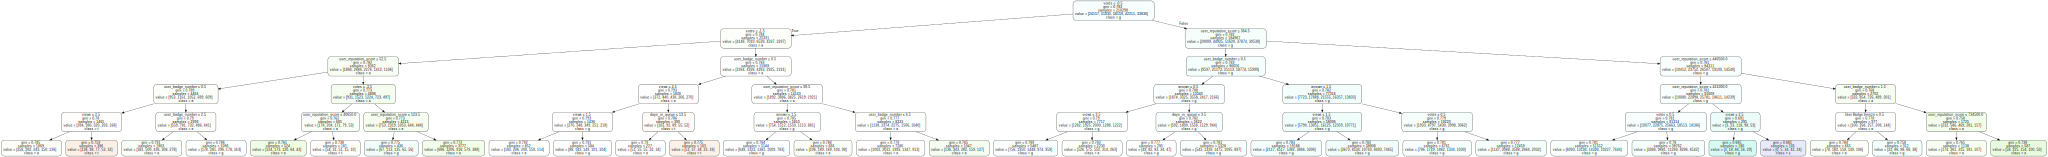

In [161]:
dot_data = tree.export_graphviz(dt_model, out_file=None,  feature_names=column_name,  
                   class_names='tags_count',  
   filled=True, rounded=True,  
               special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render('stackoverflow')
graph

In [162]:
dt_model.classes_

array([1, 2, 3, 4, 5])

In [163]:
dt_feature_knn = stack_features.copy().drop(columns=['user_badge_type','encoded_user_badge'])
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dt_feature_knn)
    distortions.append(kmeanModel.inertia_)

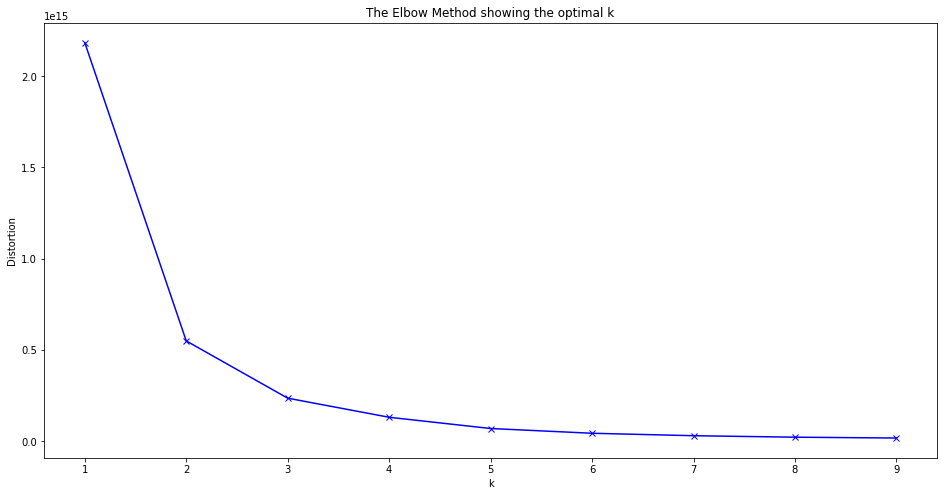

In [164]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [165]:
km = KMeans(n_clusters = 3, random_state=0)
cluster_labels = km.fit_predict(dt_feature_knn)
centroids = km.cluster_centers_

In [166]:

#silhouette_score_avg = silhouette_score(dt_feature_knn, cluster_labels)
#silhouette_score_each = silhouette_samples(dt_feature_knn, cluster_labels)

model_filename = 'api/model/kmeans_3_clusters.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(km, f)

In [167]:
cluster_info = pd.concat([dt_feature_knn, pd.DataFrame({'label_class':cluster_labels})], axis = 1)


In [168]:
cluster_info.label_class.value_counts()

0    200557
1      7273
2      2468
Name: label_class, dtype: int64

In [169]:
silhouette_score_avg = silhouette_score(dt_feature_knn, cluster_labels)
silhouette_score_avg